# Full Train Workflow

Run when you need to train a new classifier from scratch. Will regenerate transient data, refit all samples, and retrain the classifier.

## Step 0: Update configuration file.

In the same folder as this notebook, there is a $\texttt{config.yaml}$ file, which contains all filepaths and configuration options for the training workflow. Please update this now!

The most important filepath arguments are:
* $\texttt{create-dirs}$: Probably keep set to True. Create any data subdirectories that are missing.
* $\texttt{data-dir}$: This is where all generated data is stored. Set to the root directory for all outputs.
* $\texttt{relative-dirs}$: If true, all data for each step is stored within subdirectories of data_dir.
* $\texttt{transient-data-fn}$: This is where all transient data is stored as a TransientGroup. Technically a directory but loaded as a single file. If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{sampler-results-fn}$: Where light curve fits are stored. If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{figs-dir}$: Where all figures are stored (only generated if $\texttt{plot}$ is set to True). If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{models-dir}$: Where all classification models are stored. If relative_dirs is True, is created as a subdirectory of data_dir.

The most important sampling and classifier arguments are:
* $\texttt{sampler}$: Set to either dynesty or svi (all lowercase). SVI is faster but forces the posterior into a multivariate Gaussian.
* $\texttt{model-type}$: Set to either LightGBM (recommended) or MLP.
* $\texttt{use-redshift-features}$: If True, includes peak absolute magnitude and redshift as training features.
* $\texttt{fits-per-majority}$: Oversamples such that the majority class has this many samples fed into the classifier. Minority classes will correspond to more input samples per event. Defaults to 5.
* $\texttt{target-label}$: For binary classification - this is the positive label. Set to None for multiclass classification.
* $\texttt{n-folds}$: Number of K-folds. I usually set to 10.
* $\texttt{num-epochs}$: Number of estimators for LightGBM or number of training epochs for MLP.
* $\texttt{n-parallel}$: Number of threads to parallelize data import + sampling over.
* $\texttt{random-seed}$: For reproducibility.

## Step 1: Generate new TransientSet

Here we will import data from TNS + ALeRCE and generate a new TransientSet, from a list of event names. Names can be from TNS or ZTF.

The below code block will retrieve all spectroscopically classified TNS transients. Feel free to change to your own list of names or import script.

In [ ]:
from snapi.query_agents import TNSQueryAgent
tns_agent = TNSQueryAgent()
#tns_agent.update_local_database() # IMPORTANT: run this line if first time using SNAPI or if you want to reimport TNS csv
all_names = tns_agent.retrieve_all_names() # only spectroscopically classified
all_names = [x for x in all_names if int(x[:4]) > 2018] # because pre-2019 templates are pretty bad
print(len(all_names), all_names[:5])

14286 ['2024adhf', '2024addv', '2024acsd', '2024achm', '2024aazo']


The following script will import data for all provided names and generate a TransientGroup object. Will run in parallel across n_cores threads.

For the entire TNS dataset (~16000 events), this takes ~30 minutes on 8 parallel cores.

In [4]:
from superphot_plus.config import SuperphotConfig
from superphot_plus.data_generation import import_all_names

config = SuperphotConfig.from_file("config.yaml")
save_dir = config.transient_data_fn

# import data for all_names from query agents
import_all_names(
    all_names, save_dir,
    checkpoint_freq=1024,
    n_cores=config.n_parallel,
    overwrite=False
) # set overwrite=False to continue from where left off

6292 events already saved.
1287 names to query across 8 cores.
Processing 1287 transients in batch


Finished processing, making transient group now
Total transients saved: 6395.


In [5]:
# Let's check the TransientGroup we created!
from snapi import TransientGroup
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)

print(len(transient_group.metadata))
print(transient_group.metadata.head())
print(transient_group.metadata.groupby('spec_class').count())

6395
                  ra        dec                     internal_names spec_class  \
id                                                                              
2019J     150.944878   6.773457  ZTF19aacxrab, ATLAS19cay, PS18crs     SLSN-I   
2019aaby  108.702453  53.718130                       ZTF19acmbhvv      SN Ia   
2019aafe  349.068683  48.428444                       ZTF19abzfxel     SN IIn   
2019aah   225.377973   4.878289  ZTF19aadypig, ATLAS19bxf, PS19cuq      SN II   
2019aamp  219.455292  20.304611                       ZTF19aantokv     SLSN-I   

          redshift  
id                  
2019J     0.120000  
2019aaby  0.062406  
2019aafe  0.074000  
2019aah   0.030000  
2019aamp  0.404000  
                     ra   dec  internal_names  redshift
spec_class                                             
AGN                  26    26              26        26
CV                   85    85              85        52
Galaxy                2     2               2         2


Finally, before fitting, we want to phase and normalize all the photometry. This is because our samplers expect light curves to already be phased and normalized before fitting.

## Step 2 (Option 1): Fit all transients using SVI (faster)

Here, we choose to fit our transients using stochastic variational inference (SVI). If using this option, make sure sampler='superphot_svi' in the config.yaml file. This option is faster but assumes Gaussianity of the posterior space, which can be limiting for certain light curve fits.

For all 7202 TNS transients passing quality cuts, this takes ~30 minutes.

In [1]:
from snapi.scripts import fit_transient_group
from snapi import TransientGroup, SamplerResultGroup
from superphot_plus.samplers.numpyro_sampler import SVISampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig
import os

config = SuperphotConfig.from_file("config.yaml")

priors = generate_priors(["ZTF_r","ZTF_g"])
svi_sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=config.random_seed,
)

transient_group = TransientGroup.load(config.transient_data_fn)
print("Transient group loaded")

result = fit_transient_group(
    transient_group,
    sampler = svi_sampler,
    parallelize=True,
    n_parallel=config.n_parallel,
    checkpoint_fn = os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    ),
    checkpoint_freq = 512,
    pad=True,
    overwrite=True # set to False to continue where left off
)
SamplerResultGroup(result).save(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

2024-12-09 09:59:03,540 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 09:59:03,542 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


Transient group loaded


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-09 09:59:23,041 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 09:59:23,041 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 09:59:23,042 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 09:59:23,045 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'li

Finished checkpoint 1 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-09 10:01:02,645 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:01:02,647 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:01:02,649 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libt

Finished checkpoint 2 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-09 10:02:42,987 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:02:42,987 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:02:42,987 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:02:42,989 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 3 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-09 10:04:31,926 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:04:31,928 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:04:31,928 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:04:31,929 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 4 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-09 10:06:25,305 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:06:25,305 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:06:25,305 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:06:25,306 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 5 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-09 10:08:22,772 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:08:22,772 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:08:22,774 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:08:22,774 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'li

Finished checkpoint 6 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-09 10:10:10,739 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:10:10,740 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:10:10,741 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:10:10,741 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'li

Finished checkpoint 7 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-09 10:11:54,868 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:11:54,872 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:11:54,871 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:11:54,873 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 8 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-09 10:13:38,428 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:13:38,429 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:13:38,428 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:13:38,431 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'li

Finished checkpoint 9 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-09 10:15:22,982 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:15:22,982 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:15:22,982 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:15:22,983 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 10 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-09 10:17:06,476 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:17:06,476 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:17:06,476 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:17:06,476 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 11 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-09 10:20:12,553 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:20:12,554 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:20:12,556 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 10:20:12,554 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 12 of 12


6395          A_ZTF_r_median  beta_ZTF_r_median  gamma_ZTF_r_median  \
id                                                               
2024zxe        1.060066           0.006515           21.559340   
2024zxx        1.008632           0.004957           10.922216   
2024zxy        0.999871           0.003068           10.698563   
2024zzh        1.048144           0.003795           10.976669   
2024zzy        1.050948           0.006389           17.307053   

         t_0_ZTF_r_median  tau_rise_ZTF_r_median  tau_fall_ZTF_r_median  \
id                                                                        
2024zxe        -10.272728               2.442825              67.799133   
2024zxx        -10.537067               2.722696              30.501999   
2024zxy        -10.864374               3.129445              25.643831   
2024zzh        -11.220001               5.660433              21.290213   
2024zzy        -11.350541               0.793693              22.185860   

      

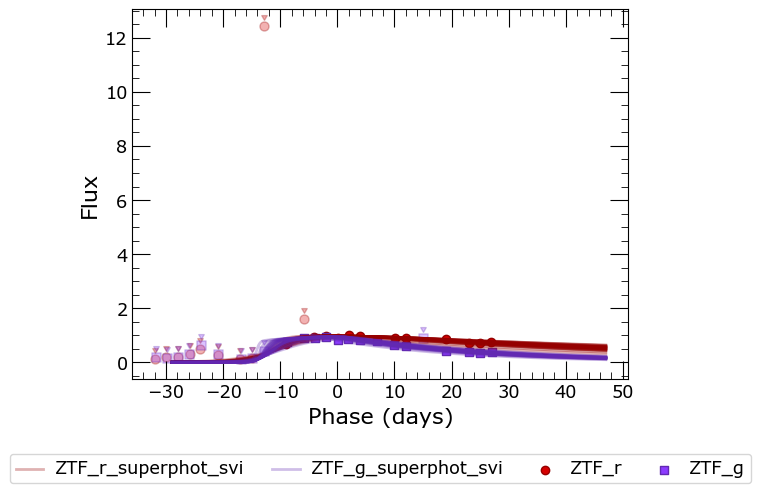

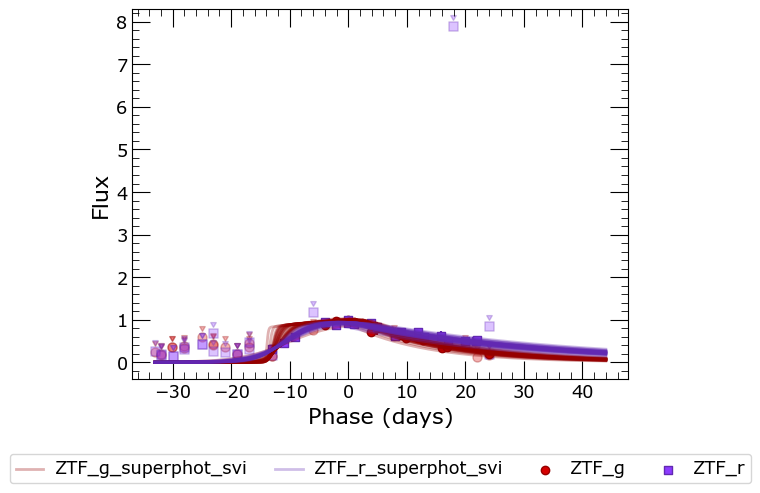

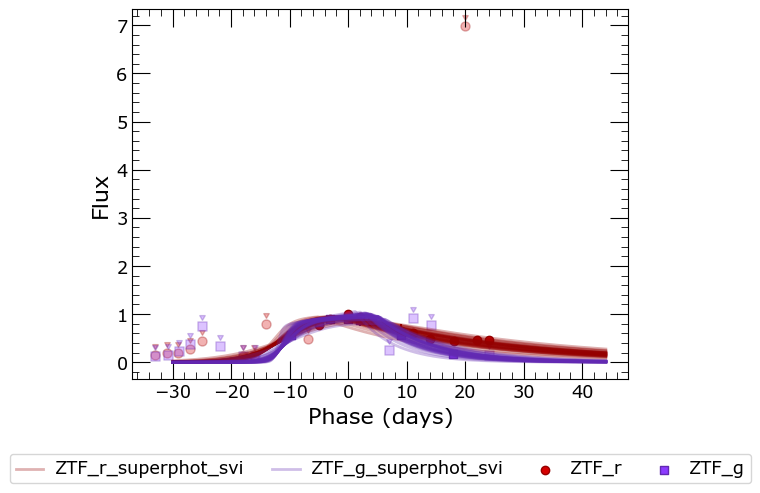

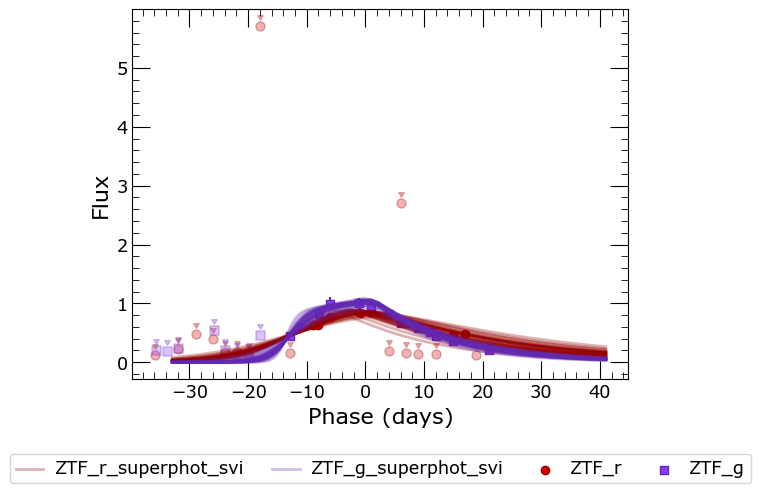

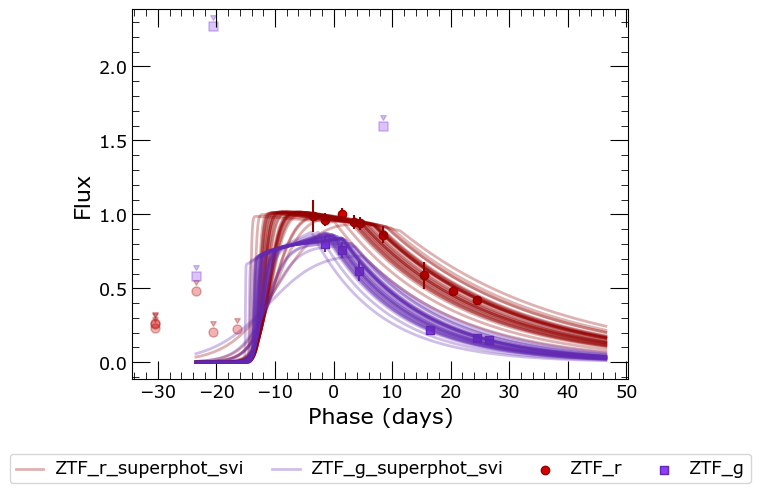

In [2]:
# sanity check plot
import os
import matplotlib.pyplot as plt

from snapi import TransientGroup, SamplerResultGroup, Formatter
from superphot_plus.samplers.numpyro_sampler import SVISampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
sampler_results = SamplerResultGroup.load(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

priors = generate_priors(["ZTF_r","ZTF_g"])
svi_sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=config.random_seed,
)

print(len(sampler_results), sampler_results.metadata.tail())
names = sampler_results.metadata.index

formatter = Formatter()
for n in names[-5:]:
    t = transient_group[n] # can index like dictionary
    sr = sampler_results[n]
    svi_sampler.load_result(sr)
    
    fig, ax = plt.subplots()
    svi_sampler.plot_fit(
        ax,
        photometry = t.photometry,
        formatter = formatter,
    )
    formatter.reset_colors()
    formatter.reset_markers()
    t.photometry.plot(
        ax,
        mags=False,
        formatter=formatter
    )
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)
    formatter.reset_colors()
    formatter.reset_markers()
    
    plt.show()
    

## Step 2 (Option 2): Fit light curves using dynesty (slower)

Here, we fit our transient photometry using the dynesty nested sampler. This is slower but does not assume Gaussianity of the posterior space, so can better capture degeneracies between parameters. If you use this, make sure to set sampler=superphot_dynesty in the config.yaml file.

Runtime for 7202 TNS samples: ~200 minutes (3.5 hours)

In [ ]:
from snapi.scripts import fit_transient_group
from snapi import TransientGroup, SamplerResultGroup
from superphot_plus.samplers.dynesty_sampler import DynestySampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")

transient_group = TransientGroup.load(config.transient_data_fn)
print("Transient group loaded")

priors = generate_priors(["ZTF_r","ZTF_g"])

dynesty_sampler = DynestySampler(
    priors=priors,
    random_state=config.random_seed,
)

result = fit_transient_group(
    transient_group,
    sampler = dynesty_sampler,
    parallelize=True,
    n_parallel=config.n_parallel,
    checkpoint_fn = os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    ),
    checkpoint_freq = 128,
    pad=False,
    overwrite=True, # False to continue from checkpoint
)
SamplerResultGroup(result).save(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    ),
)


Transient group loaded


/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/dynesty/dynamicsampler.py:530: RuntimeWarning: All the initial likelihood values are the same. You likely have a plateau in the likelihood. Nested sampling may not be the best sampler in this case.
  warnings.warn(
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:33:39,406 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:33:39,406 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03

Finished checkpoint 0 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:36:53,847 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:36:53,847 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:36:53,847 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:36:53,847 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 1 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:40:30,579 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:40:30,579 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:40:30,579 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:40:30,579 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 2 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:44:05,388 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:44:05,388 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:44:05,388 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:44:05,389 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 3 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:47:44,712 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:47:44,713 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:47:44,714 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:47:44,715 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 4 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:51:17,464 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:51:17,464 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:51:17,464 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:51:17,465 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 5 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()


KeyboardInterrupt: 

/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/dynesty/dynamicsampler.py:530: RuntimeWarning: All the initial likelihood values are the same. You likely have a plateau in the likelihood. Nested sampling may not be the best sampler in this case.
  warnings.warn(


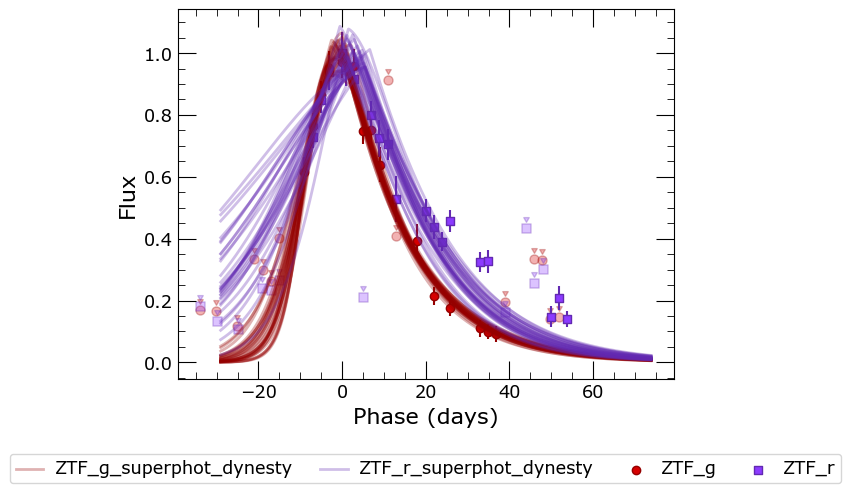

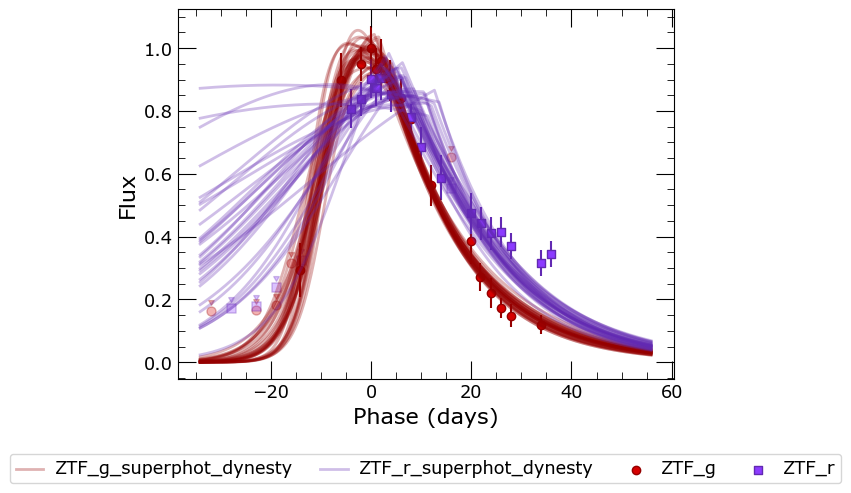

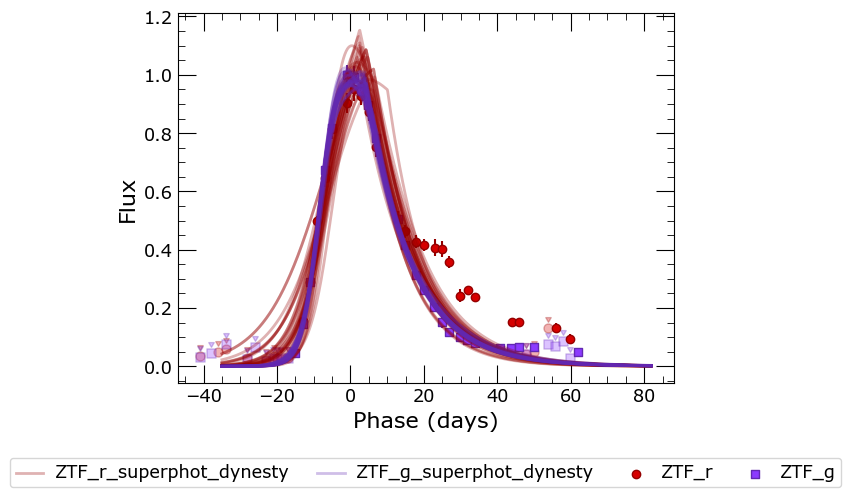

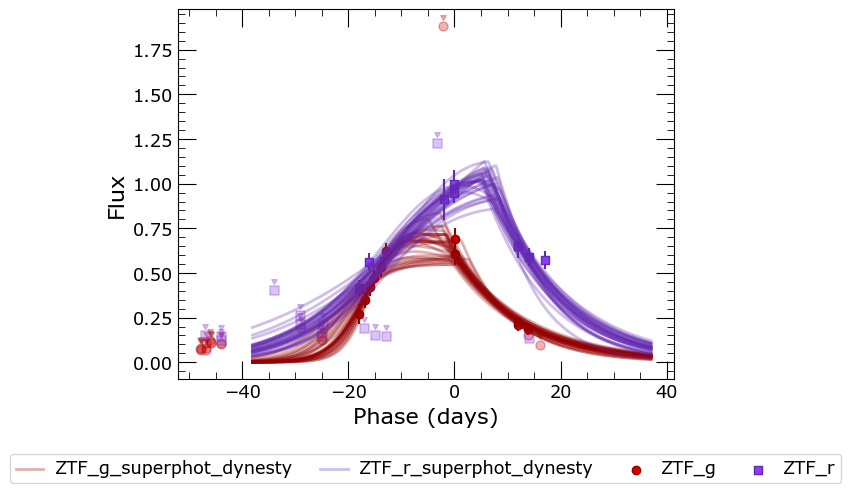

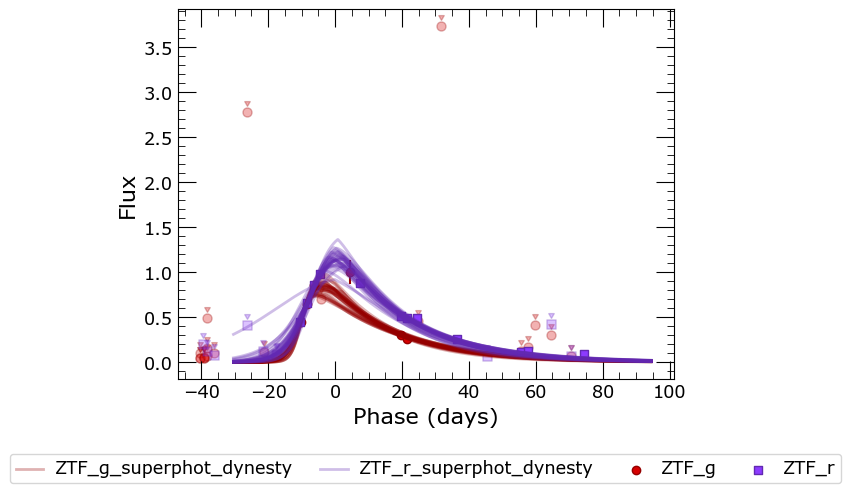

In [ ]:
# sanity check plot
import os
import matplotlib.pyplot as plt

from snapi import TransientGroup, SamplerResultGroup, Formatter
from superphot_plus.samplers.dynesty_sampler import DynestySampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
sampler_results = SamplerResultGroup.load(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

priors = generate_priors(["ZTF_r","ZTF_g"])

svi_sampler = DynestySampler(
    priors=priors,
    random_state=config.random_seed,
)

names = sampler_results.metadata.index

formatter = Formatter()
for n in names[-5:]: # neweet 
    t = transient_group[n] # can index like dictionary
    sr = sampler_results[n]
    svi_sampler.load_result(sr)
    
    fig, ax = plt.subplots()
    svi_sampler.plot_fit(
        ax,
        photometry = t.photometry,
        formatter = formatter,
    )
    formatter.reset_colors()
    formatter.reset_markers()
    t.photometry.plot(
        ax,
        mags=False,
        formatter=formatter
    )
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)

    formatter.reset_colors()
    formatter.reset_markers()
    
    plt.show()
    

## Step 2.5: Convert SamplerResultGroup posteriors back to uncorrelated Gaussians

When sampling, the posteriors are saved as the inputs to our flux model. The Gaussian priors, however, were converted to log-Gaussians and multiplied by base parameters where necessary before being fed into the model function. Therefore, we must revert these log-Gaussian and relative parameters back to their original uncorrelated Gaussian draws before using as classifier inputs. We do this below:

In [3]:
# warning: only run once!
import os
from snapi import SamplerResultGroup
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")

priors = generate_priors(["ZTF_r","ZTF_g"])
sampler_results = SamplerResultGroup.load(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

new_sr = []
for i, sr in enumerate(sampler_results):
    if i % 1000 == 0:
        print(f"Converted {i} out of {len(sampler_results)} fits")
    sr.fit_parameters = priors.reverse_transform(sr.fit_parameters)
    new_sr.append(sr)
    
new_sampler_results = SamplerResultGroup(new_sr)
new_sampler_results.save(config.sampler_results_fn)


Converted 0 out of 6395 fits
Converted 1000 out of 6395 fits
Converted 2000 out of 6395 fits
Converted 3000 out of 6395 fits
Converted 4000 out of 6395 fits
Converted 5000 out of 6395 fits
Converted 6000 out of 6395 fits


## Step 3: Train + evaluate classifier from sampling posteriors

Here we train a classifier with our uncorrelated posterior features. This script will automatically split the data into K-folds, oversample the training and validation sets to even out minority classes, and train either LightGBMs (recommended) or MLPs. If plot is True, metric plots and confusion matrices will also be generated.

In [1]:
from superphot_plus import SuperphotConfig, SuperphotTrainer

config = SuperphotConfig.from_file("config.yaml")
trainer = SuperphotTrainer(config)
trainer.run()

Finally, we train a version of the classifier without a test set (aka we use the entire dataset in training or validation). This is what we'll be using to classify a new, disparate dataset.

In [1]:
from superphot_plus import SuperphotConfig, SuperphotTrainer
from snapi import TransientGroup, SamplerResultGroup

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
srg = SamplerResultGroup.load(config.sampler_results_fn)

trainer = SuperphotTrainer(config)
trainer.setup_model()
meta_df = trainer.retrieve_transient_metadata(transient_group)
train_df, val_df = trainer.split(meta_df, split_frac=0.1)
train_srg = srg.filter(train_df.index)
val_srg = srg.filter(val_df.index)

trainer.train(0, (train_df, train_srg), (val_df, val_srg))
trainer.models[0].save(config.model_prefix + "_full")

# train early-type
trainer.config.input_features = [
    "A_ZTF_r",
    "beta_ZTF_r",
    "t_0_ZTF_r",
    "tau_rise_ZTF_r",
    "extra_sigma_ZTF_r",
    "A_ZTF_g",
    "beta_ZTF_g",
    "t_0_ZTF_g",
    "tau_rise_ZTF_g",
    "extra_sigma_ZTF_g",
]

trainer.train(1, (train_df, train_srg), (val_df, val_srg))
trainer.models[1].save(config.model_prefix + "_early")

2024-12-08 21:47:59,082 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-08 21:47:59,084 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


In [ ]:
from superphot_plus import SuperphotConfig, SuperphotTrainer, SuperphotLightGBM
from snapi import TransientGroup, SamplerResultGroup

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
srg = SamplerResultGroup.load(config.sampler_results_fn)

trainer = SuperphotTrainer(config)
trainer.setup_model()
meta_df = trainer.retrieve_transient_metadata(transient_group)

trainer.models[0] = SuperphotLightGBM.load(config.model_prefix + "_full.pt")
print(trainer.models[0].best_model.feature_name_)
trainer.models[1]= SuperphotLightGBM.load(config.model_prefix + "_early.pt")
probs_avg = trainer.evaluate(0, (meta_df, srg))
probs_avg.to_csv(config.probs_fn[:-4] + "_full.csv")

# train early-type
trainer.config.input_features = [
    "A_ZTF_r",
    "beta_ZTF_r",
    "t_0_ZTF_r",
    "tau_rise_ZTF_r",
    "extra_sigma_ZTF_r",
    "A_ZTF_g",
    "beta_ZTF_g",
    "t_0_ZTF_g",
    "tau_rise_ZTF_g",
    "extra_sigma_ZTF_g",
]

probs_avg_early = trainer.evaluate(1, (meta_df, srg))
probs_avg_early.to_csv(config.probs_fn[:-4] + "_early.csv")

A_ZTF_r               0.040580
beta_ZTF_r            0.004967
gamma_ZTF_r           1.079022
t_0_ZTF_r           -18.261330
tau_rise_ZTF_r        0.196180
tau_fall_ZTF_r        1.477941
extra_sigma_ZTF_r    -1.863424
A_ZTF_g              -0.088600
beta_ZTF_g           -0.015048
gamma_ZTF_g           0.209774
t_0_ZTF_g            -0.873970
tau_rise_ZTF_g        0.009889
tau_fall_ZTF_g       -0.371240
extra_sigma_ZTF_g    -0.314438
dtype: float32
A_ZTF_r               0.126805
beta_ZTF_r            0.009827
gamma_ZTF_r           1.674477
t_0_ZTF_r           -22.448669
tau_rise_ZTF_r        0.999661
tau_fall_ZTF_r        1.595848
extra_sigma_ZTF_r    -2.180087
A_ZTF_g              -0.232226
beta_ZTF_g           -0.019849
gamma_ZTF_g          -0.126259
t_0_ZTF_g            -8.976661
tau_rise_ZTF_g       -0.319423
tau_fall_ZTF_g       -0.046385
extra_sigma_ZTF_g     0.181098
dtype: float32


AttributeError: 'SamplerResultGroup' object has no attribute '_2020fcx'